# Regular activity test

In [2]:
from datetime                      import datetime
import invalid_sample_detection    as invalid
import load_annotations            as annotate
import matplotlib.pyplot           as plt
import numpy                       as np
import parameters
import wfdb
import math

%matplotlib inline
%config IPCompleter.greedy=True


data_path = 'sample_data/challenge_training_data/'
ann_path = 'sample_data/challenge_training_multiann/'
ecg_ann_type = 'gqrs'

## RR intervals tests

In [3]:
# Check if standard deviation of RR intervals of signal are within limits
def check_rr_stdev(rr_intervals): 
    stdev = np.std(rr_intervals)
            
    if stdev > parameters.RR_STDEV: 
        return False
    return True

# Check if heart rate, calculated by number of RR intervals in signal, are within limits
def check_heart_rate(rr_intervals, alarm_duration): 
    hr = (len(rr_intervals) + 1.) / alarm_duration * parameters.NUM_SECS_IN_MIN
            
    if hr > parameters.HR_MAX or hr < parameters.HR_MIN: 
        return False
    return True

# Check if sum of RR intervals is within limit of total duration, to ensure beats are evenly spaced throughout
def check_sum_rr_intervals(rr_intervals, alarm_duration): 
    min_sum = alarm_duration - parameters.RR_MIN_SUM_DIFF
        
    rr_sum = sum(rr_intervals)
        
    if rr_sum < min_sum: 
        return False
    return True    

# Check if total number of RR intervals is greater than a minimum 
def check_num_rr_intervals(rr_intervals): 
    if len(rr_intervals) < parameters.MIN_NUM_RR_INTERVALS: 
        return False
    return True

## Invalids tests

In [4]:
# Returns False if any block within signal is identified as invalid (invalid sample detection)
def check_invalids(invalids, channel): 
    if channel not in invalids.keys(): 
        raise Exception("Unknown channel")
    
    block_invalids_sum = sum(invalids[channel])
    if block_invalids_sum > parameters.INVALIDS_SUM: 
        return False
    return True

## Putting it all together

Helper methods to check classification of alarms and whether the algorithm classified alarm correctly: 

In [5]:
# Returns type of alarm and whether gold standard classified alarm as true or false
def check_gold_standard_classification(fields): 
    alarm_type, alarm_classification = fields['comments']
    
    if "True" in alarm_classification: 
        is_true_alarm = True
    else:
        is_true_alarm = False
        
    return alarm_type, is_true_alarm

# Check if our classification matches with gold standard classification of true/false alarm nature
def is_classified_correctly(is_true_alarm, is_regular): 
    is_classified_true_alarm = not is_regular
    matches = is_true_alarm is is_classified_true_alarm
    if matches: 
        return "\nMatches! Alarm was a " + str(is_true_alarm) + " alarm"
    else:
        return "\n" + str(is_true_alarm) + " alarm classified as a " + str(is_classified_true_alarm).lower() + " alarm"

### Check interval regular activity

In [6]:
# Returns True for a given channel if all regular activity tests checked pass
def check_interval_regular_activity(rr_intervals, invalids, alarm_duration, channel,
                                    should_check_invalids, should_check_rr, should_num_check): 
    all_checks = np.array([])
    
    if should_check_rr: 
        # If the RR intervals should be checked but all annotations missing, auto fail
        if len(rr_intervals) == 0: 
            return False
        
        stdev_check = check_rr_stdev(rr_intervals)
        hr_check = check_heart_rate(rr_intervals, alarm_duration)
        sum_check = check_sum_rr_intervals(rr_intervals, alarm_duration)
        
        all_checks = np.append(all_checks, [stdev_check, hr_check, sum_check])
    
    if should_num_check:
        num_check = check_num_rr_intervals(rr_intervals)
        all_checks = np.append(all_checks, [num_check])
    
    if should_check_invalids: 
        invalids_check = check_invalids(invalids, channel)
        all_checks = np.append(all_checks, invalids_check)
                
    return np.all(all_checks)

### Check regular activity for sample

In [1]:
# Check overall sample for regular activity by iterating through each channel.
# If any channel exhibits regular activity, alarm indicated as false alarm.
def is_sample_regular(data_path, 
                      ann_path, 
                      sample_name, 
                      ecg_ann_type, 
                      start=None, 
                      end=None, 
                      should_check_invalids=True,
                      should_check_rr=True,
                      should_num_check=True,
                      should_check_nan=True): 
    sig, fields = wfdb.rdsamp(data_path + sample_name)
    channels = fields['signame']
    
    if start is None or end is None: 
        start, end, alarm_duration = invalid.get_start_and_end(fields)
    else: 
        alarm_duration = end - start
            
    invalids = {}    
    if should_check_invalids: 
        invalids = invalid.calculate_invalids_sig(sig, fields, start, end, should_check_nan)

    for channel_index in range(len(channels)): 
        channel = channels[channel_index]
        channel_type = invalid.get_channel_type(channel)
        
        # Ignore respiratory channel
        if channel_type == "Resp": 
            continue
            
        rr = np.array([])
        if should_check_rr: 
            rr = annotate.get_channel_rr_intervals(ann_path, sample_name, channel_index, fields, ecg_ann_type)
            
        is_regular = check_interval_regular_activity(rr, invalids, alarm_duration, channel, should_check_invalids,
                                                     should_check_rr, should_num_check)
                
        # If any channel exhibits regular activity, deem signal as regular activity
        if is_regular: 
            return True
    return False

# sample_name = "v135l"
# print is_sample_regular(data_path, ann_path, sample_name, ecg_ann_type)

### Check regular activity of intermediate data

In [5]:
# Determines regular activity of sample based on RR intervals and invalids array: 
# param: rr_dict as a dictionary of the form: 
#         { channel0: [rr_intervals], channel1: [rr_intervals], ...}
# param: alarm_duration duration of alarm in seconds
def is_rr_invalids_regular(rr_dict, invalids, alarm_duration,
                           should_check_invalids=True, should_check_rr=True, should_num_check=True): 

    for channel in rr_dict.keys(): 
        channel_type = invalid.get_channel_type(channel)
        rr_intervals = rr_dict[channel]
        
        is_regular = check_interval_regular_activity(rr_intervals, invalids, alarm_duration, channel, 
                                                     should_check_invalids, should_check_rr, should_num_check)
        
        # If any channel is regular, reject alarm as false alarm
        if is_regular: 
            return True
    return False        
        

0.00546769527406
False {'II': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.]), 'PLETH': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.]), 'V': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.])}
[ 1.  1.  1.  1.  0.]
0.160668682698
True {'II': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.]), 'PLETH': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.]), 'V': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.])}
[ 0.  1.  1.  1.  1.]
0.454588241308
True {'II': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.]), 'PLETH': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.]), 'V': array([ 0.,  0.,  0., 

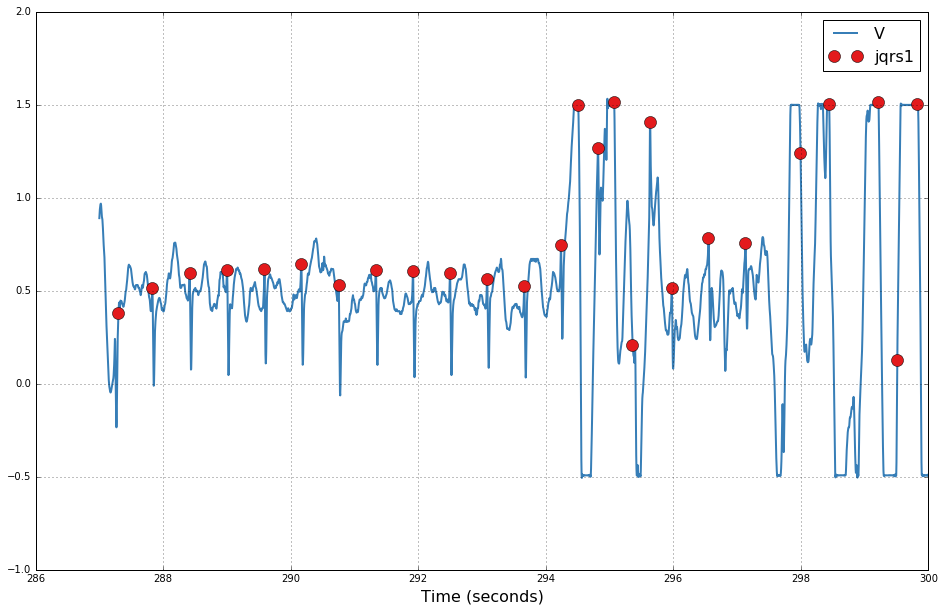

In [40]:
if __name__ == '__main__': 
    data_path = 'sample_data/challenge_training_data/'
    ann_path = 'sample_data/challenge_training_multiann/'
    sample_name = 'f792s'
    ecg_ann_type = 'jqrs'
        
    sig, fields = wfdb.rdsamp(data_path + sample_name)
    alarm_type, is_true_alarm = check_gold_standard_classification(fields)
    start, end, alarm_duration = invalid.get_start_and_end(fields)    
    
    is_regular = is_sample_regular(data_path, ann_path, sample_name, ecg_ann_type)

    print is_classified_correctly(is_true_alarm, is_regular)
    
    annotate.plot_annotations(data_path, ann_path, sample_name, ['jqrs1'], 1, fields['fs'], start, end)